# __Text summarization using Python__

## __Imports__

In [144]:
from attention import AttentionLayer

import numpy as np  
import pandas as pd
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

# Visualizations
import matplotlib.pyplot as plt

# Splitting the data
from sklearn.model_selection import train_test_split

# Model building
from keras import backend as K 

## __Understanding and preparing the data__

## Reading the data

In [145]:
food_reviews_df = pd.read_csv("./Reviews.csv", quoting=3, error_bad_lines=False)

Output hidden; open in https://colab.research.google.com to view.

## Drop duplicates and NA values

In [146]:
food_reviews_df.drop_duplicates(subset=['Text'], inplace=True)
food_reviews_df.dropna(axis=0, inplace=True)

## Preprocesing

Here is the dictionary that we'll use for expanding the contractions.

In [147]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

## Text cleaning

In [148]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    new_string = text.lower()
    new_string = BeautifulSoup(new_string, "lxml").text
    new_string = re.sub(r'\([^)]*\)', '', new_string)
    new_string = re.sub('"','', new_string)
    new_string = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_string.split(" ")])    
    new_string = re.sub(r"'s\b","",new_string)
    new_string = re.sub("[^a-zA-Z]", " ", new_string) 
    new_string = re.sub('[m]{2,}', 'mm', new_string)
    if(num==0):
        tokens = [w for w in new_string.split() if not w in stop_words]
    else:
        tokens=new_string.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [149]:
#call the function
cleaned_text = []
for t in food_reviews_df['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [150]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'right mostly sprouting cats eat grass love rotate around wheatgrass rye',
 'healthy dog food good digestion also good small puppies dog eats required amount every feeding']

In [151]:
#call the function
cleaned_summary = []
for t in food_reviews_df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [152]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'cough medicine',
 'yay barley',
 'healthy dog food',
 'fresh and greasy',
 'strawberry twizzlers yummy',
 'poor taste',
 'love it',
 'home delivered twizlers']

In [153]:
food_reviews_df['cleaned_text'] = cleaned_text
food_reviews_df['cleaned_summary'] = cleaned_summary

In [154]:
food_reviews_df.replace('', np.nan, inplace=True)
food_reviews_df.dropna(axis=0,inplace=True)

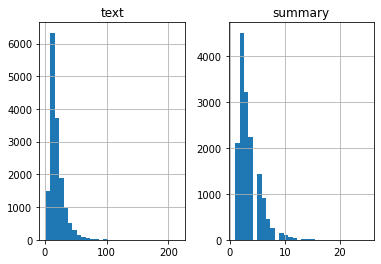

In [155]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in food_reviews_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in food_reviews_df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [156]:
cnt = 0
for i in food_reviews_df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(food_reviews_df['cleaned_summary']))

0.9747559095580678


We observe that 94.60 % of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let's fix the maximum length of review to 30, since it's seen the majority of reviews have length below 30.

In [157]:
max_text_len=30
max_summary_len=8

Let's select the reviews and summaries whose length falls below or equal to max_text_len and max_summary_len.

In [158]:
cleaned_text = np.array(food_reviews_df['cleaned_text'])
cleaned_summary = np.array(food_reviews_df['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df = pd.DataFrame({'text': short_text,'summary': short_summary})

We need to add the START and END special tokens at the beginning and end of the summary. Here, I have chosen \_START_ and \_END_ as START and END tokens.

__Note__: the chosen special tokens must never appear in the summary.

In [159]:
df['summary'] = df['summary'].apply(lambda x: 'starttoken ' + x + ' endtoken')

Before training the model, we need to split our dataset into a training and test set. We’ll use 90 % of the dataset as the training data and evaluate the performance on the remaining 10 % (holdout set).

In [160]:
X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

## Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

In [161]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

## Rarewords and its coverage

Let us look at the proportion rare words and its total coverage in the entire text.

Let's define the threshold to be 4 which means word whose count is below 4 is considered as a rare word.

In [162]:
thresh = 4

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq+value
    if(value<thresh):
        cnt = cnt + 1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 67.69925782510488
Total Coverage of rare words: 6.168031283088891


__Remember:__

* __tot_cnt__ gives the size of vocabulary (which means every unique words in the text)

* __cnt__ gives  the no. of rare words whose count falls below threshold

* __"tot_cnt - cnt"__ gives  the top most common words

Let's define the tokenizer with top most common words for reviews.

In [163]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(X_train) 
x_val_seq = x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
X_test = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1


In [164]:
x_voc

4005

## Sumary Tokenizer

In [165]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

## Rarewords and its coverage

Let us look at the proportion rare words and its total coverage in the entire summary.

Let's define the threshold to be 6 which means word whose count is below 6 is considered as a rare word.

In [166]:
thresh = 6

cnt = 0
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value
    if(value < thresh):
        cnt = cnt + 1
        freq = freq + value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 83.08742567716362
Total Coverage of rare words: 10.51475519785379


Let's define the tokenizer with top most common words for summary.

In [168]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_test   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Let's check whether word count of start token is equal to length of the training data.

In [169]:
y_tokenizer.word_counts['starttoken'],len(y_train)

(11817, 11817)

Now we'll delete the rows that contain only __START__ and __END__ tokens.

In [170]:
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt = cnt + 1
    if(cnt == 2):
        ind.append(i)

y_train = np.delete(y_train, ind, axis=0)
X_train = np.delete(X_train,ind, axis=0)

In [171]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test = np.delete(y_test,ind, axis=0)
X_test = np.delete(X_test,ind, axis=0)

## __Model building__

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

__Return Sequences = True__: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

__Return State = True__: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

__Initial State__: This is used to initialize the internal states of the LSTM for the first timestep

__Stacked LSTM__: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [172]:
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      400500      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [173]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

The concept of early stopping is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases.

In [174]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Let's train the model on a batch size of 128 and validate it on the holdout set (which is 10 % of our dataset).

In [175]:
history = model.fit([X_train,y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/50
88/88 [==============================] - 56s 493ms/step - loss: 2.6612 - val_loss: 2.2574
Epoch 2/50
88/88 [==============================] - 42s 477ms/step - loss: 2.2328 - val_loss: 2.1489
Epoch 3/50
88/88 [==============================] - 42s 481ms/step - loss: 2.1368 - val_loss: 2.1135
Epoch 4/50
88/88 [==============================] - 42s 473ms/step - loss: 2.0799 - val_loss: 2.0538
Epoch 5/50
88/88 [==============================] - 41s 465ms/step - loss: 2.0170 - val_loss: 2.0039
Epoch 6/50
88/88 [==============================] - 41s 470ms/step - loss: 1.9539 - val_loss: 1.9418
Epoch 7/50
88/88 [==============================] - 41s 462ms/step - loss: 1.8971 - val_loss: 1.9237
Epoch 8/50
88/88 [==============================] - 41s 461ms/step - loss: 1.8472 - val_loss: 1.8895
Epoch 9/50
88/88 [==============================] - 41s 469ms/step - loss: 1.8004 - val_loss: 1.8667
Epoch 10/50
88/88 [==============================] - 40s 460ms/step - loss: 1.7579 - val_lo

## __Understanding the diagnostic plot__

Now, we will plot a few diagnostic plots to understand the behavior of the model over time.

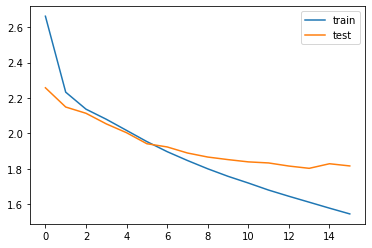

In [176]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 14 for 2 successive epochs. Hence, training is stopped at epoch 16.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary

In [177]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## __Inference__

Set up the inference for the encoder and decoder.

In [178]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

The function below is the implementation of the inference process.

In [179]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let's define the functions to convert an integer sequence to a word sequence for summary as well as the reviews.

In [180]:
def seq2summary(input_seq):
    new_string=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttoken']) and i!=target_word_index['endtoken']):
            new_string=new_string+reverse_target_word_index[i]+' '
    return new_string

def seq2text(input_seq):
    new_string=''
    for i in input_seq:
        if(i!=0):
            new_string=new_string+reverse_source_word_index[i]+' '
    return new_string

Here are a few summaries generated by the model.

In [181]:
for i in range(0,100):
    print("Review:", seq2text(X_train[i]))
    print("Original summary:", seq2summary(y_train[i]))
    print("Predicted summary:", decode_sequence(X_train[i].reshape(1, max_text_len)))
    print("\n")

Review: picky food used lots different frontier products several spice companies frontier highest quality 
Original summary: have found to be high quality 
Predicted summary:  love it


Review: son restricted diet due allergies picky hard find things would even try tasting one cookies hooked favorite snack 
Original summary: my is on diet 
Predicted summary:  great treat


Review: love plant arrived perfectly packaged sits kitchen looks beautiful 
Original summary: money tree 
Predicted summary:  great food


Review: never realized anything tiny could wonderful first taste dark chocolate wonderful refreshing taste simply divine 
Original summary: best healthy treat ever tasted 
Predicted summary:  the best chocolate ever


Review: got bag costco yesterday cannot seem get hand 
Original summary: addicting to this 
Predicted summary:  great product


Review: quality tea star sealed bags trying see helps skin 
Original summary: very fresh tea 
Predicted summary:  great tea


Review: great

Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

This is how we can perform text summarization using deep learning concepts in Python.

## __Evaluating the perfomance of the model based on the BLEU score__

In [210]:
from nltk.translate.bleu_score import sentence_bleu

for i in range(0,100):
    print("Review:", seq2text(X_train[i]))
    original_summary = seq2summary(y_train[i])
    print("Original summary:", original_summary)
    predicted_summary = decode_sequence(X_train[i].reshape(1, max_text_len))
    print("Predicted summary:", predicted_summary)
    reference = original_summary.split()
    candidate = predicted_summary.split()
    print(f'BLEU score -> {sentence_bleu([reference], candidate, weights=(1, 0, 0, 0))}')
    print("\n")

Review: picky food used lots different frontier products several spice companies frontier highest quality 
Original summary: have found to be high quality 
Predicted summary:  love it
BLEU score -> 0


Review: son restricted diet due allergies picky hard find things would even try tasting one cookies hooked favorite snack 
Original summary: my is on diet 
Predicted summary:  great treat
BLEU score -> 0


Review: love plant arrived perfectly packaged sits kitchen looks beautiful 
Original summary: money tree 
Predicted summary:  great food
BLEU score -> 0


Review: never realized anything tiny could wonderful first taste dark chocolate wonderful refreshing taste simply divine 
Original summary: best healthy treat ever tasted 
Predicted summary:  the best chocolate ever
BLEU score -> 0.38940039153570244


Review: got bag costco yesterday cannot seem get hand 
Original summary: addicting to this 
Predicted summary:  great product
BLEU score -> 0


Review: quality tea star sealed bags tryi

Something important to have in mind is that __BLEU doesn’t consider meaning__

For me, this is the single most compelling reason not to rely solely on BLEU for evaluating models. As a human user, my main goal is to accurately understand the underlying meaning of the text in the original summarization. I’ll happily accept some syntactic or grammatical weirdness in the output sentence as long as it’s true to the meaning of the original.

__BLEU does not measure meaning__. It only rewards systems for n-grams that have exact matches in the reference system. That means that a difference in a function word (like “an” or “on”) is penalized as heavily as a difference in a more important content word. It also means that a summarization that had a perfectly valid synonym that just didn’t happen to show up in the reference summarization will be penalized.

## __Future lines of research__

* __Increasing the training dataset__ size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size ✅

* Implementing __Bi-Directional LSTM__ which is capable of capturing the context from both the directions and results in a better context vector

* Using the __beam search strategy__ for decoding the test sequence instead of using the greedy approach (argmax)

* Evaluating the performance of your model based on the __BLEU score__ ✅

* Implementing __pointer-generator networks__ and __coverage mechanisms__